In [1]:
import matplotlib.pyplot as plt
import pandas as pd
myCsv="F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds\FoldData.csv"
df = pd.read_csv(myCsv)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [2]:
i=0
myTrain=df.loc[(df['Fold']==i) & (df['Type']=='Train')].copy()
myTest=df.loc[(df['Fold']==i) & (df['Type']=='Test')].copy()

In [3]:
baseDir="F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds"
labelCount=myTrain['Label'].value_counts()
print(labelCount)
condLabelCount=myTrain['condLabel'].value_counts()
print(condLabelCount)

Label
10_T02 M06 (VHM 309-12)      360
2_T02 M06 (VHM 309-12)       225
11_T03 M06 (VHM 309-6)       190
4_T08 M06 (MECHE3.7 MD)      179
12_T06 M06 (VHM 309-3)       173
13_T23 M06 (CHANF8)          140
5_T09 M06 (MECHE4.6 MD)       53
7_T10 M06 (MECHE5.5 MD)       46
9_T24 M06 (FRSURF50X5)        37
3_T14 M06 (MECHE5.3)          36
6_T19 M06 (MECHE MD D4.8)     14
8_T05 M06 (MECHE MD D5.8)     13
1_T07 M06 (MECHE MD D4.2)      4
14_T22 M06 (CHANF3)            4
Name: count, dtype: int64
condLabel
VHM       948
MECHMD    309
CHANF     144
FRSURF     37
MECHE      36
Name: count, dtype: int64


## Downsampling and drop of minorities classes

Prendre 1 sur 3 pour "10_T02" et "2_T02" => 195 datapoints
Augmenter par 4 5_T09, 7_T10 => (212, 196)
Augmenter par 5 9_T24, 3_T14 => (185, 190)
Augmenter par 13 6_T19 et 8_T05 => (182, 169)
Drop 1_T07 et 14_T22 


In [4]:
myTrain=myTrain.drop(myTrain[(myTrain['Label']=='1_T07 M06 (MECHE MD D4.2)') | (myTrain['Label']=='14_T22 M06 (CHANF3)')].index)

In [5]:
myDataDecreaseResamp=myTrain[(myTrain['Label']=='10_T02 M06 (VHM 309-12)') | (myTrain['Label']=='2_T02 M06 (VHM 309-12)')].iloc[::3].copy()

In [6]:
myTrain=myTrain.drop(myTrain[(myTrain['Label']=='10_T02 M06 (VHM 309-12)') | (myTrain['Label']=='2_T02 M06 (VHM 309-12)')].index)

In [7]:
myTrain=pd.concat([myTrain,myDataDecreaseResamp])


In [18]:
del myDataDecreaseResamp

# Data augmentation

In [8]:
DataToIncreaseBy4=myTrain[(myTrain['Label']=='5_T09 M06 (MECHE4.6 MD)') | (myTrain['Label']=='7_T10 M06 (MECHE5.5 MD)')].copy()
DataToIncreaseBy5=myTrain[(myTrain['Label']=='9_T24 M06 (FRSURF50X5)') | (myTrain['Label']=='3_T14 M06 (MECHE5.3)')].copy()
DataToIncreaseBy12=myTrain[(myTrain['Label']=='6_T19 M06 (MECHE MD D4.8)') | (myTrain['Label']=='8_T05 M06 (MECHE MD D5.8)')].copy()


### Data augmentation functions

In [9]:
import numpy as np
import os 
import csv

def get_file_duration(file_path, fs):
    try:
        ext = os.path.splitext(file_path)[1]

        # For .csv files
        if ext in [".csv"]:
           with open(file_path, 'r', newline='', encoding="utf-8") as csvfile:
            raw_data = csvfile.read().replace("\r\n", "")  # Supprimer les retours à la ligne
            myReader= list(csv.reader([raw_data], delimiter=','))
            return  float(len(myReader[0])/fs) #Duration in seconds

        # Other types of files
        else:
            return None  # Pas de durée disponible

    except Exception as e:
        print(f"Error with : {file_path}: {e}")
        return None

In [10]:
durs=[]
myDir="F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds"
for row in myTrain.iterrows():
    dirFile=os.path.join(myDir,row[1]['Dir'])
    durs.append(get_file_duration(os.path.join(dirFile,row[1]['Snd']),50000))




In [12]:
print("Max duration is : " + str(np.max(durs)))

Max duration is : 5.00124


In [13]:
from scipy.ndimage import zoom
from scipy.signal import butter, filtfilt

import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import numpy as np 

class DataUtils():
    #---------------------------------------------
    #Load a file and returns it as a list
    #---------------------------------------------
    @staticmethod
    def loadFile(mySndFile, myAccXFile, myAccYFile, myAccZFile):
        """Load a file."""
    
        def read_csv_to_numpy(filepath):
            """Read CSV file and convert it to a NumPy array of int16."""
            with open(filepath, 'r', newline='', encoding="utf-8") as csvfile:
                reader = csv.reader(csvfile, delimiter=',')
                data = [list(map(np.int16, row)) for row in reader]  # Convertir chaque valeur en int
            return np.array(data, dtype=np.int16).flatten()  # Aplatir si nécessaire
        
        # Charger chaque signal
        sound = read_csv_to_numpy(mySndFile)
        accelX = read_csv_to_numpy(myAccXFile)
        accelY = read_csv_to_numpy(myAccYFile)
        accelZ = read_csv_to_numpy(myAccZFile)
        
        # Empiler correctement en un tableau `(4, 250062)`
        return np.stack([sound, accelX, accelY, accelZ], axis=-1)
    @staticmethod
    def saveFile(myNpy, destDir, fileName):
        """Save a file."""
        np.save(os.path.join(destDir, fileName), myNpy)

    #---------------------------------------------
    #Align the data to have a fixed duration.
    #---------------------------------------------
    @staticmethod
    def padTruncate(mySig, maxTime, fs):
        """Pad or truncate the data to have a fixed duration.
        Args:
            mySig: the signal as a list
            maxTime: The maximum time in milliseconds.
            fs: the sampling rate in Hz    
            """
        sLen = mySig.shape[0]
        trunc=0
        maxLen=int(maxTime*int(fs/1000))
        if sLen > maxLen:
            trunc=1
            mySig = mySig[:, :maxLen]
        elif sLen < maxLen:
            trunc=-1
            mySig = np.pad(mySig, (0, int(maxLen - sLen)), mode='wrap')
        
        return (trunc, len(mySig), mySig)
    
    def addGaussianNoise(mySig, std=0.02):
        """Add a gaussian noise."""
        mySig_float=mySig.astype(np.float32)
        noise = np.random.normal(0, std*np.std(np.abs(mySig_float), axis=0), mySig.shape)
        noisySig=np.clip(mySig_float+noise, -32768,32767)        
        return noisySig.astype(np.int16)
    
    def timeShift(mySig, shift_lim=0.5):
        """Shifts the data in time (reintroduce ending values at the beginning."""
        _, sLen = mySig.shape
        shiftAmt = int(np.random.random() * shift_lim * sLen)
        return np.roll(mySig, shiftAmt, axis=0)
    
    @staticmethod
    def augment_fft(data, factor=1.2):
        """Augmente ou diminue certaines fréquences du signal"""
        
        fft_data = np.fft.fft(data, axis=0)
        fft_data = fft_data * factor  # Modification du spectre
        newData=np.real(np.fft.ifft(fft_data, axis=0))  # Retourne le signal temporel
        newData = np.clip(newData, -32768, 32767)
        return newData.astype(np.int16)

    # ----------------------------
    # Generate a Mel Spectrogram Excellent for Audio Data
    # ----------------------------
    @staticmethod
    def mel_spectro_gram(mySig, n_mels=64, n_fft=1024, hop_len=None, fs=50000):
        if hop_len is None:
            hop_len = n_fft // 4
            
        top_db = 80
        mySig=mySig.astype(np.float32)
        mySigTensor=torch.from_numpy(mySig.T)
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(fs, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(mySigTensor)
        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        spec = spec.unsqueeze(0) if spec.dim() == 2 else spec
        return (spec, hop_len)
    
    # ----------------------------
    # Generate a "classic" Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(mySig, n_fft=1024, hop_len=None, fs=50000):
        if hop_len is None:
            hop_len = n_fft // 4
            
        mySig=mySig.astype(np.float32)
        mySigTensor=torch.from_numpy(mySig.T)
        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.Spectrogram(n_fft=n_fft, hop_length=hop_len, power=2)(mySigTensor)
        # Convert to decibels
        spec = transforms.AmplitudeToDB()(spec)
        spec = spec.unsqueeze(0) if spec.dim() == 2 else spec
        return (spec, hop_len)
    
    # ----------------------------
    # Visualize a Spectrogram
    # ----------------------------
    @staticmethod
    def show_spectrogram(spec, fs=50000, hop=256, title="Spectrogram", ylabel='Mel Frequency Bands', channels=['Sound', 'AccX', 'AccY', 'AccZ'], mel=True):
        nbChannels=spec.shape[0]
        fig, axs = plt.subplots(nbChannels, 1, figsize=(18, 12))
        if nbChannels==1:
            axs=[axs]
        timeAxis=np.arange(0, spec.shape[2]*hop, hop)/fs
        freqAxis = np.linspace(0, fs / 2, spec.shape[1])
        for i in range(nbChannels):
            if mel:
                img=axs[i].imshow(spec[i].detach().numpy(), aspect='auto', origin='lower', cmap='viridis', extent=[timeAxis[0], timeAxis[-1], 0, spec[i].shape[0]])
            else:
                img=axs[i].imshow(spec[i].detach().numpy(), aspect='auto', origin='lower', cmap='viridis', extent=[timeAxis[0], timeAxis[-1], freqAxis[0], freqAxis[-1]])
                
            axs[i].set_title(f"Channel {channels[i]}")
            axs[i].set_ylabel(ylabel)
        plt.xlabel('Time [s]')
        plt.suptitle(title)
        plt.colorbar(img, ax=axs, orientation='vertical')
        plt.show()
        
    # ----------------------------
    # Augment a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_Augment(spectro, maxMaskPercentage=0.1,nFreqMask=1, nTimeMasks=1):
        """Augmente ou diminue certaines fréquences du signal"""
        _, nFreq, nSteps = spectro.shape
        mask_value=spectro.mean()
        aug_spec=spectro
        freqMaskParam=maxMaskPercentage*nFreq
        for _ in range(nFreqMask):
            aug_spec=transforms.FrequencyMasking(freqMaskParam)(aug_spec, mask_value)
        
        timeMaskParam=maxMaskPercentage*nSteps
        for _ in range(nTimeMasks):
            aug_spec=transforms.TimeMasking(timeMaskParam)(aug_spec, mask_value)
        return aug_spec
        


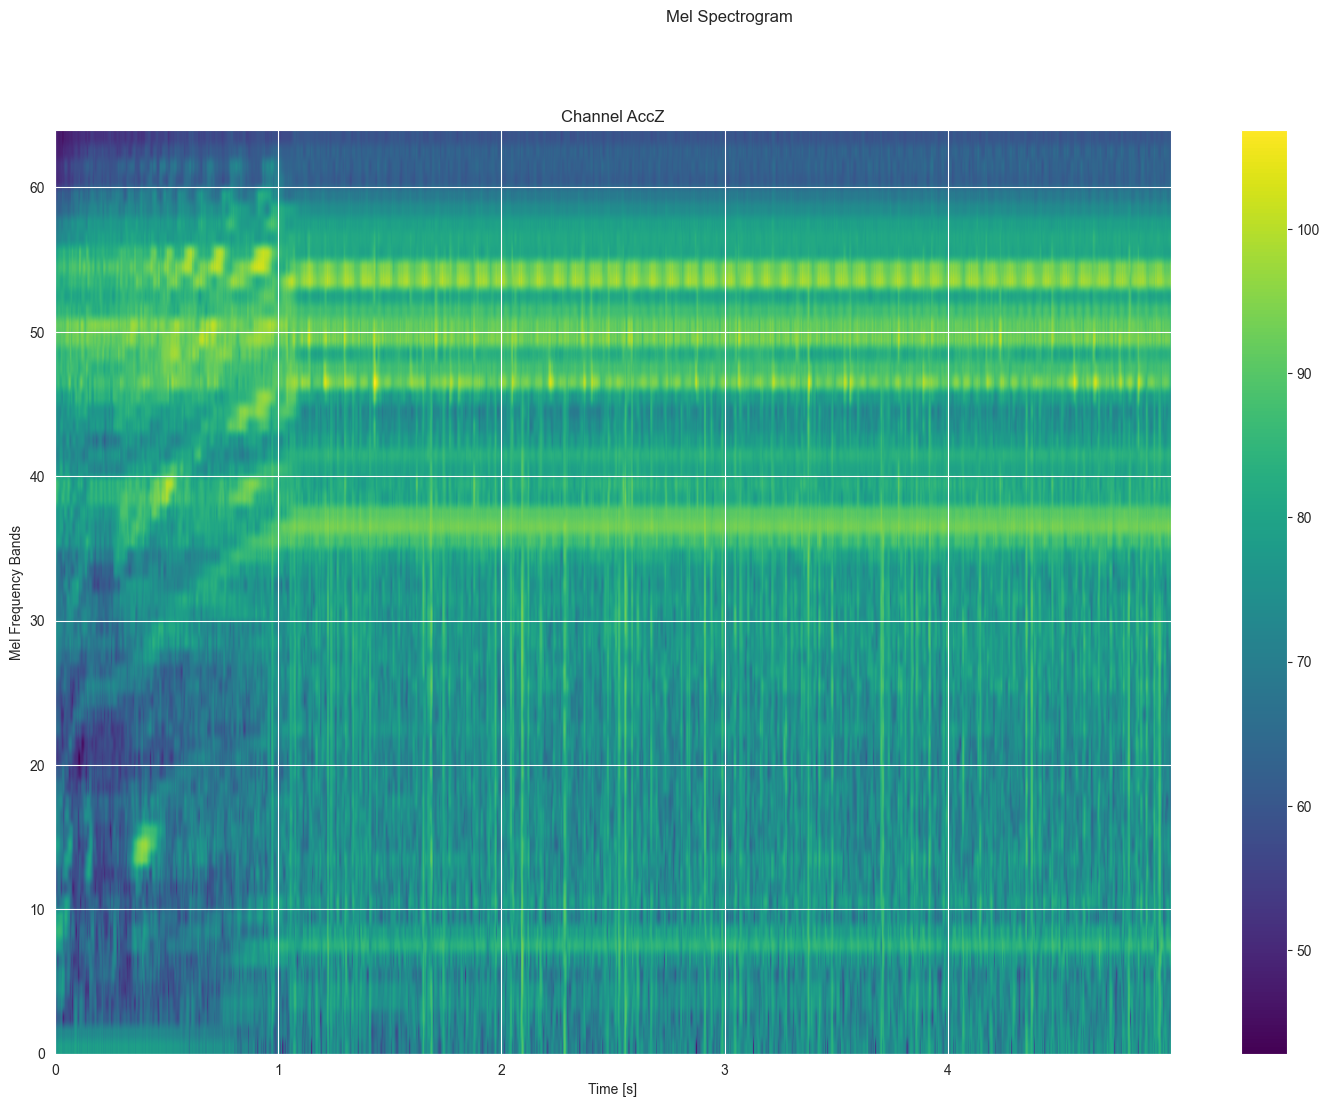

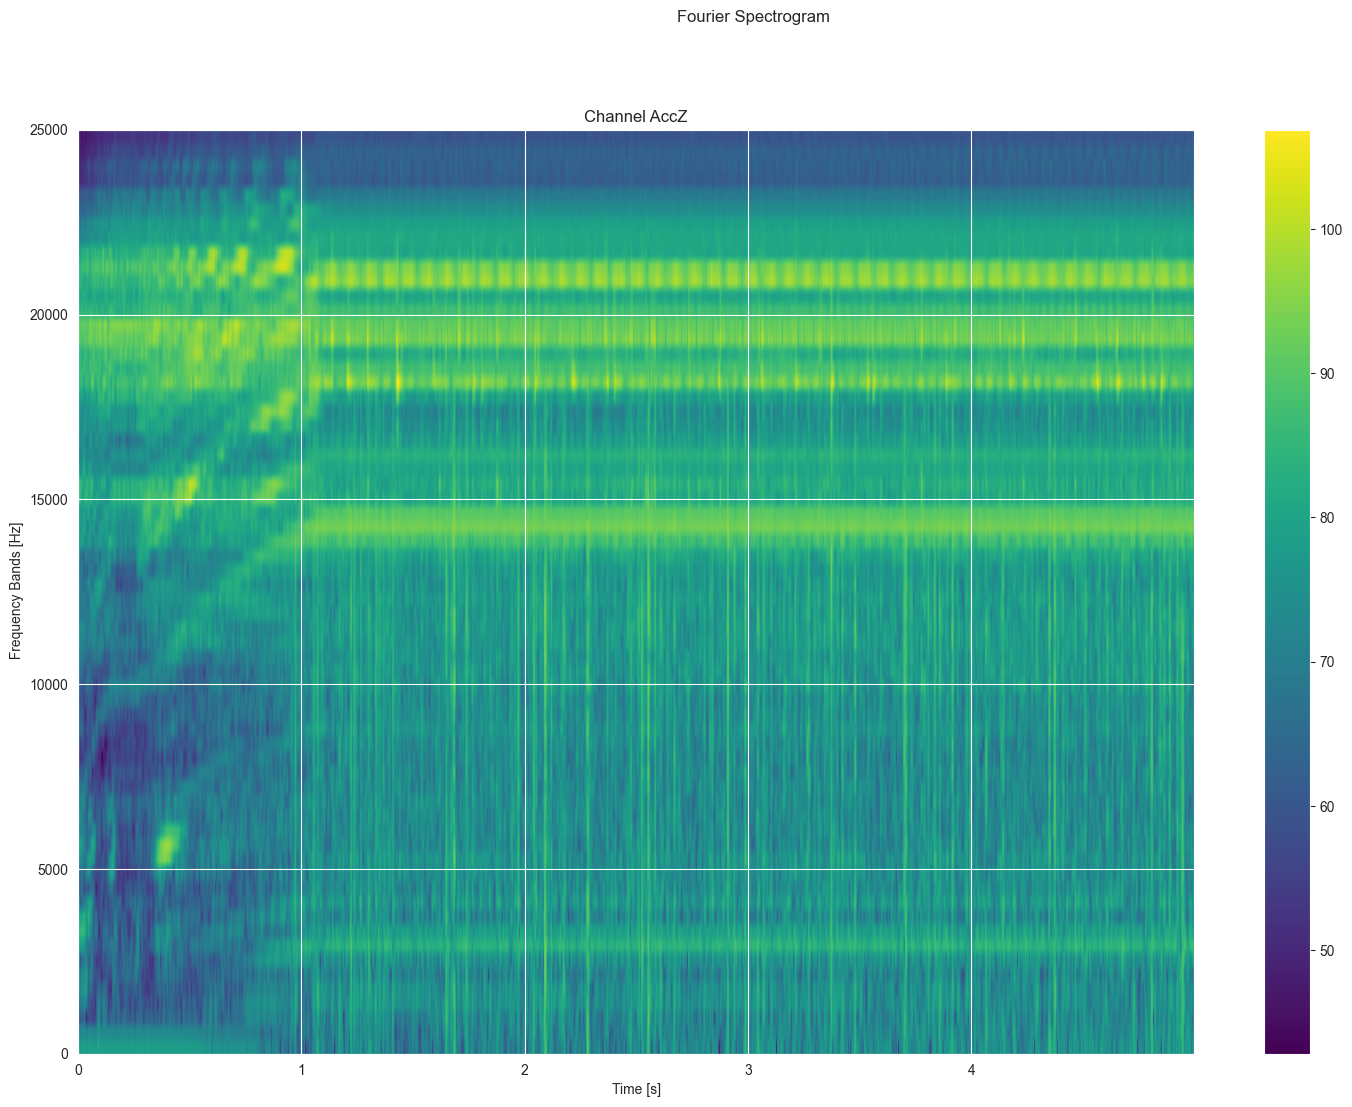

In [141]:

melspec, hop_mel = DataUtils.mel_spectro_gram(observationLoad[:,3], n_mels=64, n_fft=1024, hop_len=None, fs=50000)
spec, hop_four = DataUtils.spectro_gram(observationLoad[:,3], n_fft=1024, hop_len=None, fs=50000)

DataUtils.show_spectrogram(melspec, fs=50000, hop=hop_mel, title="Mel Spectrogram", ylabel='Mel Frequency Bands', channels=['AccZ'])

DataUtils.show_spectrogram(melspec, fs=50000, hop=hop_four, title="Fourier Spectrogram", ylabel=' Frequency Bands [Hz]', channels=['AccZ'],mel=False)


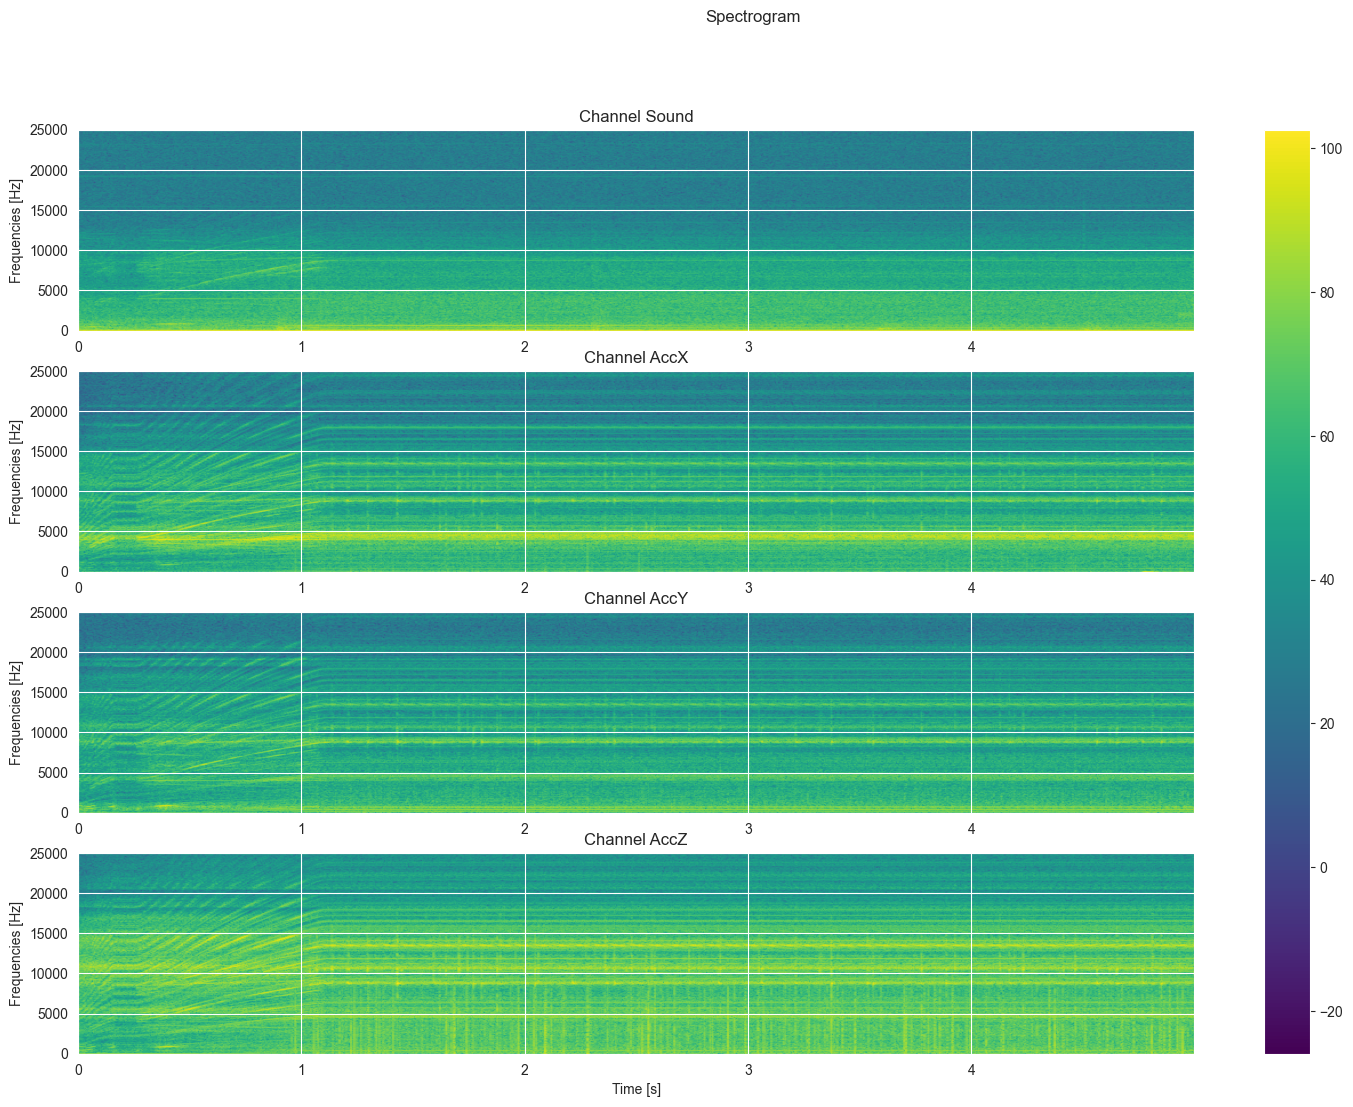

In [144]:
spec, hop_four = DataUtils.spectro_gram(observationLoad, n_fft=1024, hop_len=None, fs=50000)
DataUtils.show_spectrogram(spec, fs=50000, hop=hop_four, title="Spectrogram", ylabel='Frequencies [Hz]', channels=['Sound', 'AccX', 'AccY', 'AccZ'], mel=False)

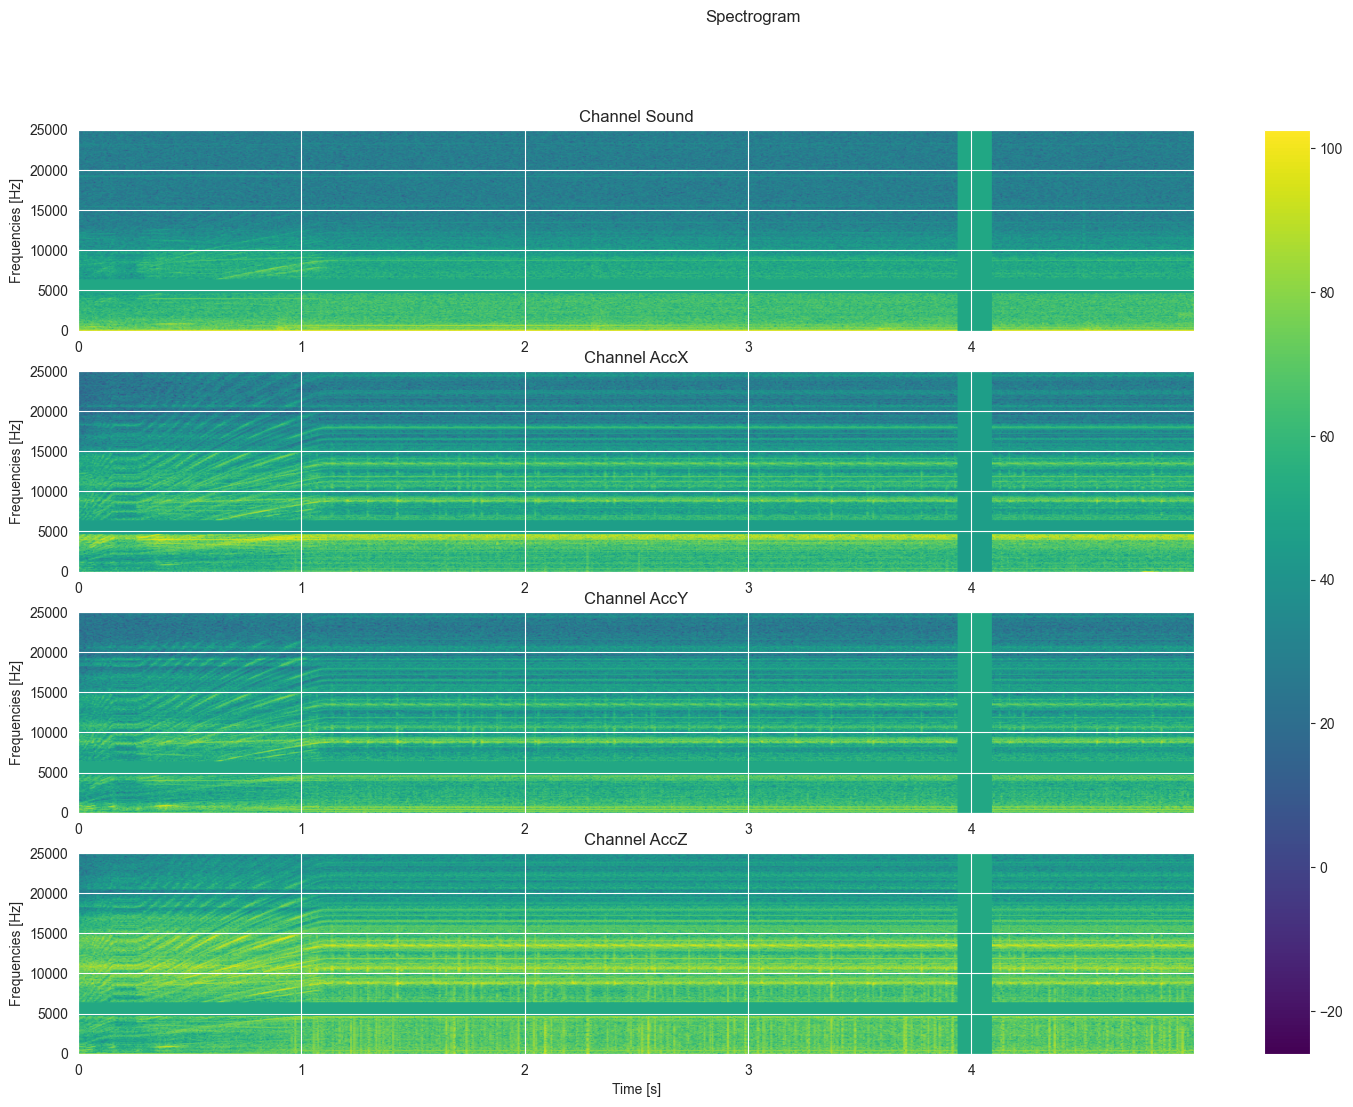

In [146]:
augspec=DataUtils.spectro_Augment(spec, maxMaskPercentage=0.1,nFreqMask=1, nTimeMasks=1)
DataUtils.show_spectrogram(augspec, fs=50000, hop=hop_four, title="Spectrogram", ylabel='Frequencies [Hz]', channels=['Sound', 'AccX', 'AccY', 'AccZ'], mel=False)

In [79]:
truncs=[]
lengths=[]
myDir="F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds"
for row in myTrain.iterrows():
    dirFile=os.path.join(myDir,row[1]['Dir'])
    mySnd=DataUtils.loadFile(os.path.join(dirFile,row[1]['Snd']))
    trunc, length, _ =DataUtils.padTruncate(mySnd, 50001.24, 50000)
    truncs.append(trunc)
    lengths.append(length)
del row, dirFile, mySnd, trunc,  length

In [25]:
from tqdm import tqdm
import os
import numpy as np 
import pandas as pd
import csv

myDir="F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds"

def csvToNpy(myTrain, i, srcDir, destDir, destDirName):
    newNpyRows=[]
    for idx, row in tqdm(myTrain.iterrows(),desc="Processing files", total=myTrain.shape[0]):
    
        observationLoad=DataUtils.loadFile(os.path.join(srcDir,row['Snd']),os.path.join(srcDir,row['AccX']),os.path.join(srcDir,row['AccY']),os.path.join(srcDir,row['AccZ']))
        fileName=str(row['Snd'].split('_')[0]+'_label_'+row['Snd'].split('_')[-1]).split('.csv')[0]+'.npy'
        DataUtils.saveFile(observationLoad, destDir, fileName)
        newNpyRows.append([row['nb'], row['Label'], row['condLabel'], fileName,os.path.join(destDirName,fileName)])
    return newNpyRows

def processFold(df, fold, dataType, mainDir, labelsToRemove= ['1_T07 M06 (MECHE MD D4.2)', '14_T22 M06 (CHANF3)'], labelsToDecrease=["10_T02 M06 (VHM 309-12)", "2_T02 M06 (VHM 309-12)"], decreaseRate=3):
    """
    Manage the conversion from .csv files with Sound, AccX, AccY and AccZ in seperate files to .npy Datasets with Snd, AccX, AccY AccZ in one files. 
        :param df: Dataframe with .csv files 
        :param fold: [0..4] if 5 folds
        :param dataType: "Train" or "Test" 
        :return: 
    """
    data = df[(df['Fold'] == fold) & (df['Type'] == dataType)].copy()
    if data.empty:
        return pd.DataFrame(columns=["Fold", "Type", "nb", "Label", "condLabel", "FileName", "FilePath"])

    # Gestion des labels à exclure ou downsampler uniquement pour Train
    if dataType == "Train":
        data = data[~data['Label'].isin(labelsToRemove)]  # Suppression des labels
        downsampled_data = data[data['Label'].isin(labelsToDecrease)].iloc[::decreaseRate].copy()
        data = data[~data['Label'].isin(labelsToDecrease)] 
        data = pd.concat([data, downsampled_data], ignore_index=True)

    # Tri des observations
    data.sort_values(by=['nb'], inplace=True)

    # Définition des répertoires
    srcDir = os.path.join(mainDir, data['Dir'].iloc[0])
    destDirName = f"{dataType.lower()}_Npy_fold_{fold}"
    destDir = os.path.join(mainDir, destDirName)
    os.makedirs(destDir, exist_ok=True)

    # Conversion et sauvegarde
    processed_data = csvToNpy(data, fold, srcDir, destDir, destDirName)

    # Création du DataFrame avec les nouvelles métadonnées
    return pd.DataFrame(processed_data, columns=["nb", "Label", "condLabel", "FileName", "FilePath"]).assign(Fold=fold, Type=dataType)[["Fold", "Type", "nb", "Label", "condLabel", "FileName", "FilePath"]]
    
myGlobalDs=pd.DataFrame(columns=["Fold", "Type", "nb", "Label", "condLabel", "FileName", "FilePath"])
for i in range(0, 5):
    myGlobalDs = pd.concat([myGlobalDs, processFold(df, i, "Test",myDir , labelsToRemove= ['1_T07 M06 (MECHE MD D4.2)', '14_T22 M06 (CHANF3)'], labelsToDecrease=["10_T02 M06 (VHM 309-12)", "2_T02 M06 (VHM 309-12)"], decreaseRate=3)], ignore_index=True)
    myGlobalDs = pd.concat([myGlobalDs, processFold(df, i, "Train",myDir , labelsToRemove= ['1_T07 M06 (MECHE MD D4.2)', '14_T22 M06 (CHANF3)'], labelsToDecrease=["10_T02 M06 (VHM 309-12)", "2_T02 M06 (VHM 309-12)"], decreaseRate=3)], ignore_index=True)



Processing files: 100%|██████████| 1076/1076 [16:50<00:00,  1.07it/s]


In [31]:
myGlobalDs.to_csv(os.path.join(myDir,f"GlobalFoldsFiles_Train_Test_orignal_Npy.csv"))

Augmenter par 4 5_T09, 7_T10 => (212, 196)     5_T09 M06 (MECHE4.6 MD)   7_T10 M06 (MECHE5.5 MD)
Augmenter par 5 9_T24, 3_T14 => (185, 190)     9_T24 M06 (FRSURF50X5)    3_T14 M06 (MECHE5.3)
Augmenter par 13 6_T19 et 8_T05 => (182, 169)  6_T19 M06 (MECHE MD D4.8) 8_T05 M06 (MECHE MD D5.8)

In [33]:
import pandas as pd
import numpy as np
from tqdm import tqdm

def newSig(obsSig):
    dice=np.random.rand()
    if 0<dice<=0.33:
        augmentedSig=DataUtils.addGaussianNoise(obsSig)
    elif 0.33<dice<=0.66:
        augmentedSig=DataUtils.timeShift(obsSig)
    else:
        augmentedSig=DataUtils.augment_fft(obsSig)
    return augmentedSig

def prepareDFandSaveAugmentedData(myDir, numToGenerate, files_to_augment, label, condLabel):
        myRows=[]
        for i in range(numToGenerate):
            fileToAugment=files_to_augment[i % len(files_to_augment)]
            newFilePath=fileToAugment.split('.npy')[0]+"_aug"+str(i)+".npy"
            myRows.append([label, condLabel, newFilePath.split("\\")[-1], newFilePath])
            
            observationLoad=np.load(os.path.join(myDir,fileToAugment))
            augmentedSig=newSig(observationLoad)
            DataUtils.saveFile(augmentedSig, myDir, newFilePath)
        return myRows



def augmentTrainingSet(myDir, myDataSetsFiles):
    if myDataSetsFiles.empty:
        return pd.DataFrame(columns=["nb", "Label", "condLabel", "FileName", "FilePath"])
    
    augmentedRows=[]
    labelCounts=myDataSetsFiles['Label'].value_counts()
    
    for label, count in tqdm(labelCounts.items(), desc="Progress", total=len(labelCounts)):
        condLabel=myDataSetsFiles[myDataSetsFiles['Label'] == label]['condLabel'].iloc[0]
        files_to_augment = myDataSetsFiles[myDataSetsFiles['Label'] == label]['FilePath'].values
        
        numToGenerate = 0
        if label in ["5_T09 M06 (MECHE4.6 MD)", "7_T10 M06 (MECHE5.5 MD)"]:
            numToGenerate=len(files_to_augment)*3 
        elif label in ["9_T24 M06 (FRSURF50X5)", "3_T14 M06 (MECHE5.3)"]:
            numToGenerate=len(files_to_augment)*4
        elif label in ["6_T19 M06 (MECHE MD D4.8)", "8_T05 M06 (MECHE MD D5.8)"]:
            numToGenerate=len(files_to_augment)*12
        else:
            continue #If label not in list, skip to next iteration
        
        augmentedRows.extend(prepareDFandSaveAugmentedData(myDir, numToGenerate, files_to_augment, label, condLabel))
    if not augmentedRows:
        return pd.DataFrame(columns=["nb", "Label", "condLabel", "FileName", "FilePath"])
    
    formattedAugRows = pd.DataFrame(augmentedRows, columns=["Label", "condLabel","FileName", "FilePath"])
    formattedAugRows.insert(0, "nb", np.nan)
    return formattedAugRows






dataType="Train"
for fold in range(0, 5):
    myDataSetsFiles=myGlobalDs[(myGlobalDs['Fold'] == fold) & (myGlobalDs['Type'] == dataType)].copy()
    myAugmentedFiles=augmentTrainingSet(myDir, myDataSetsFiles)
    myAugmentedFiles=myAugmentedFiles.assign(Fold=fold, Type=dataType)[["Fold", "Type", "nb", "Label", 'condLabel', "FilePath","FileName"]]
    
    myGlobalDs=pd.concat([myGlobalDs,myAugmentedFiles], ignore_index=True)


myGlobalDs.to_csv(os.path.join(myDir,f"GlobalFoldsFiles_Train_Test_Augmented.csv"))

#Cleaning of the memory of notebook
del myDataSetsFiles, myAugmentedFiles, dataType



Progress: 100%|██████████| 12/12 [04:37<00:00, 23.11s/it]


In [42]:
labelCounts= {}
for fold in range(0,5):
    myDataSetsFiles=myGlobalDs[(myGlobalDs['Fold'] == fold) & (myGlobalDs['Type'] == "Train")].copy()
    labelCounts[f"Train_Fold_{fold}"]=myDataSetsFiles['Label'].value_counts()
    myDataSetsFiles=myGlobalDs[(myGlobalDs['Fold'] == fold) & (myGlobalDs['Type'] == "Test")].copy()
    labelCounts[f"Test_Fold_{fold}"]=myDataSetsFiles['Label'].value_counts()

labFrame=pd.DataFrame(labelCounts)
del labelCounts, myDataSetsFiles

In [43]:
labFrame=labFrame.fillna(0)
labFrame=labFrame.div(labFrame.sum(axis=0), axis=1)*100

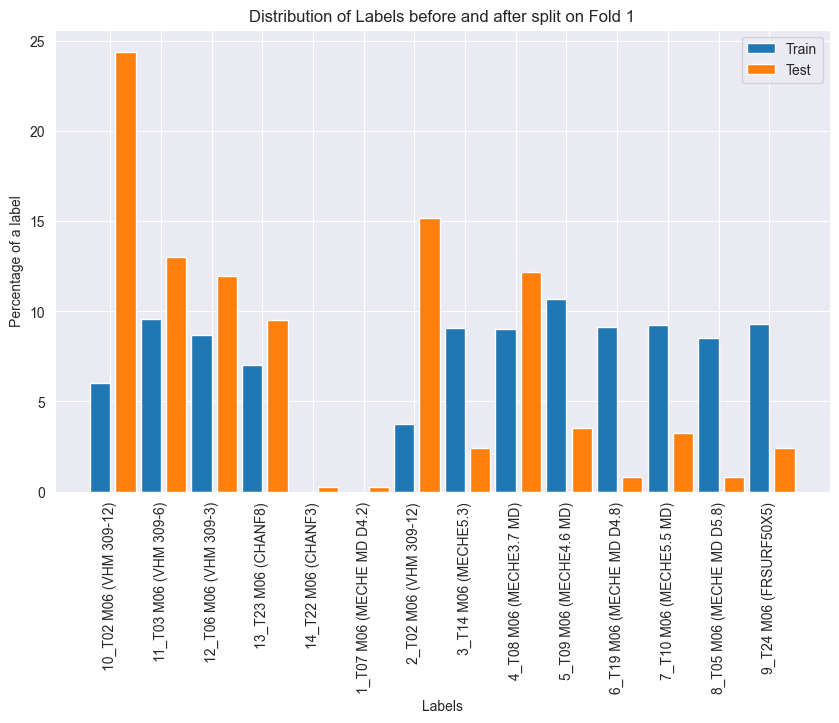

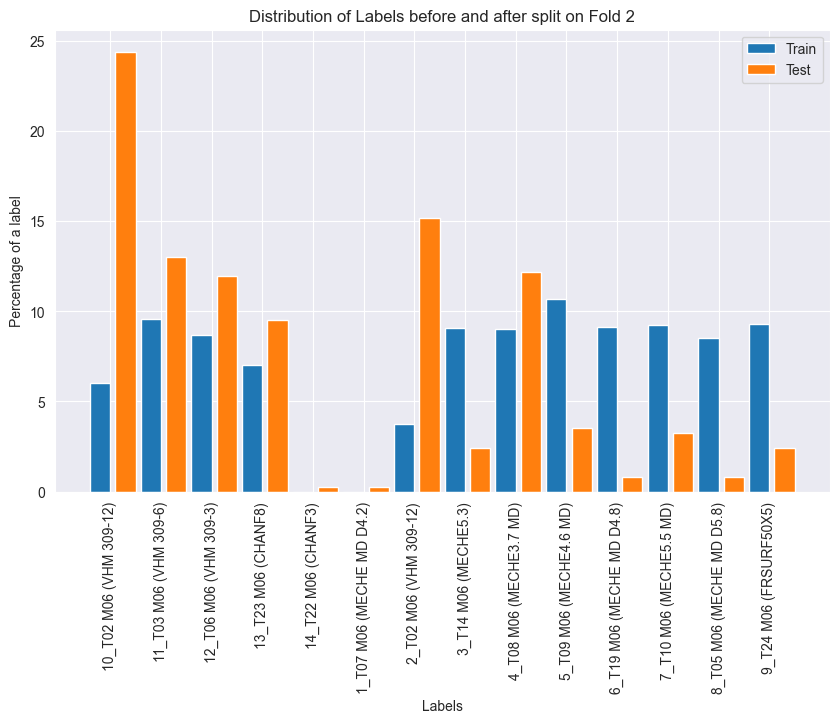

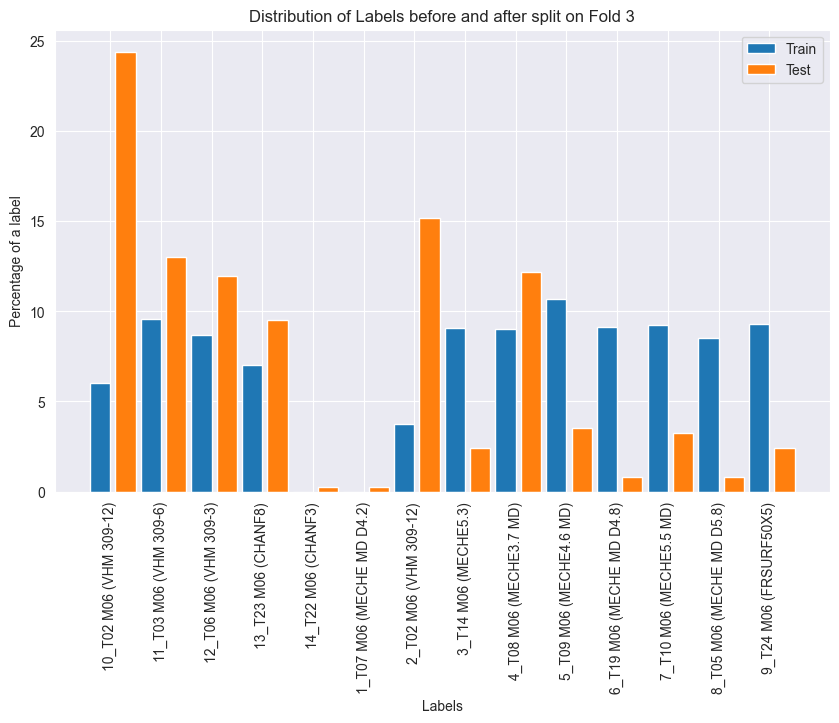

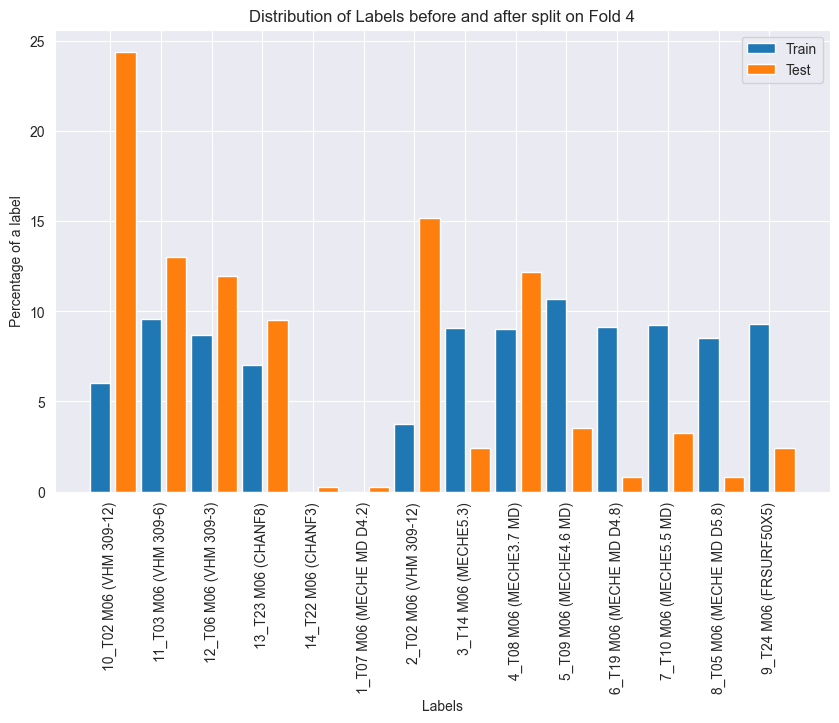

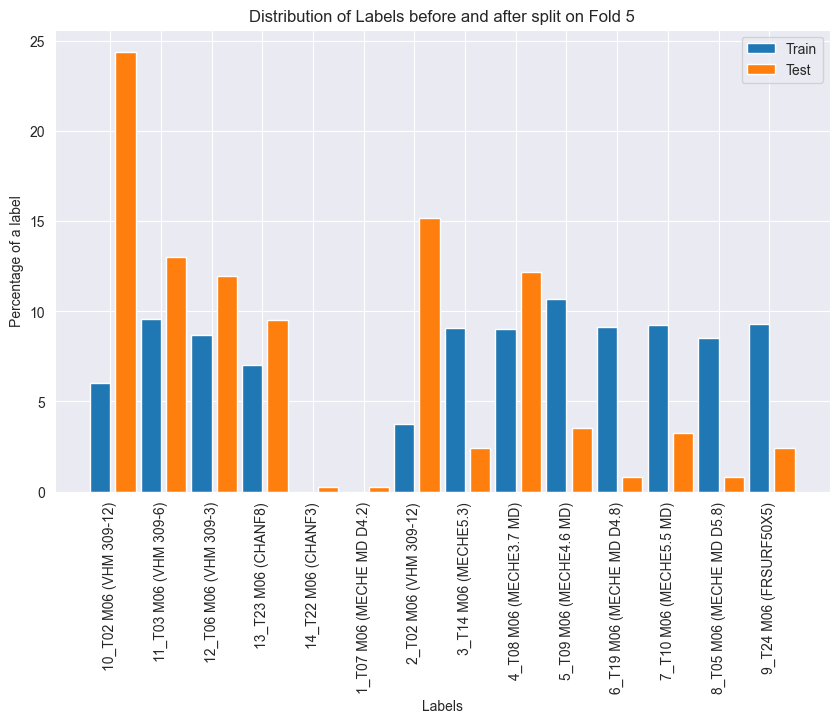

In [41]:

#Prepare a plot of distribution of data in each fold
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl

for i in range(0,5):

    X_axis = np.arange(len(labFrame)) # the label locations
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(X_axis - 0.2, labFrame[f"Train_Fold_{i}"], width=0.4, label = 'Train', ) 
    plt.bar(X_axis + 0.3 , labFrame[f"Test_Fold_{i}"], width=0.4, label = 'Test') 
    
    plt.xticks(X_axis, labFrame.index, rotation=90) 
    ax.set_title(f"Distribution of Labels after data augmentation on Fold {i+1}")
    ax.set_ylabel("Percentage of a label")
    ax.set_xlabel("Labels")
    ax.legend()

plt.show()


In [44]:
del X_axis, ax, colormaps, fig, fold, i, 

In [46]:
myDir="F:\Data_BachelorHES\DataSet_CNC\DataSetsFolds"
#load GlobalFoldsFiles_Train_Test_Augmented.csv as myGlobalDs
#load FoldData.csv as df
#Optional load GlobalFoldsFiles_Train_Test_orignal_Npy.csv if you want to retrieve the original files in .npy without the augmented files